# Crisp Store Clustering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_store_clustering.ipynb)


This page shows you how to perform clustering on a dataset of store and sales data. The dataset is a combination of sales data, product category data, and store data. The goal is to cluster stores based on the sales of different product categories.




In [ ]:
%pip install \
    tornado==6.4.1 \
    google-cloud-storage==2.18.0 \
    "google-cloud-bigquery[pandas,pyarrow]==3.25.0" \
    "pandas>=2.2.2,<3.0.0" \
    matplotlib==3.9.1 \
    "google-cloud-bigquery-storage>=2.25.0,<3.0.0" \
    "python-dotenv>=1.0.1,<2.0.0" \
    "scikit-learn>=1.5.1,<2.0.0" \
    "seaborn>=0.13.2,<0.14.0" \
    "plotly>=5.23.0,<6.0.0"

### Set Crisp environment variables if necessary

In [ ]:
import os

from google.colab import auth
auth.authenticate_user()

os.environ['CRISP_ACCOUNT_ID'] = '80047'
os.environ['BQ_SRC_PROJECT'] = '???'
os.environ['BQ_SRC_DATASET'] = f'???_{os.environ["CRISP_ACCOUNT_ID"]}'
os.environ['BQ_DEST_PROJECT'] = '???'
os.environ['BQ_DEST_DATASET'] = f'???_{os.environ["CRISP_ACCOUNT_ID"]}'
os.environ['GRPC_VERBOSITY'] = 'ERROR'

### Import the libraries used in this tutorial

In [139]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud import exceptions
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

loaded = load_dotenv()  # Load environment variables from .env file

### Load the BigQuery extension

While we heavily depend on the Python client library for BigQuery, we can also use the BigQuery magic commands to run queries directly in the notebook. The magic commands are useful for quick queries and data exploration.

In [140]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Initialize a client and prepare BigQuery for use

To use the BigQuery Python client library, start by initializing a client. The BigQuery client is used to send and receive messages from the BigQuery API.

#### Client project
The `bigquery.Client` object uses your default project. Alternatively, you can specify a project in the `Client` constructor. For more information about how the default project is determined, see the [google-auth documentation](https://google-auth.readthedocs.io/en/latest/reference/google.auth.html).

#### Client location
Locations are required for certain BigQuery operations such as creating a dataset. If a location is provided to the client when it is initialized, it will be the default location for jobs, datasets, and tables.

Run the following to create a client with your default project and prepare BigQuery for use in the rest of the notebook.

In [142]:
client = bigquery.Client(project=os.getenv("BQ_SRC_PROJECT"))
print("Client created using default project: {}.".format(client.project))

src_project = os.getenv("BQ_SRC_PROJECT")
print(f"Source project: {src_project}")
src_dataset_id = os.getenv("BQ_SRC_DATASET")
print(f"Source dataset: {src_dataset_id}")
dest_project = os.getenv("BQ_DEST_PROJECT")
print(f"Destination project: {dest_project}")
dest_dataset = os.getenv("BQ_DEST_DATASET", src_dataset_id)
print(f"Destination dataset: {dest_dataset}")

src_dateset_ref = client.dataset(project=src_project, dataset_id=src_dataset_id)
src_dataset = client.get_dataset(src_dateset_ref)

dest_dataset_ref = client.dataset(project=dest_project, dataset_id=dest_dataset)
try:
    dest_dataset = client.get_dataset(dest_dataset_ref)
except exceptions.NotFound:
    dest_dataset = client.create_dataset(dest_dataset_ref)

connector_name = "walmart"
print(f"Connector name: {connector_name}")

Client created using default project: crisp-frontier-dev.
Source project: gocrisp-greenhouse-analytics
Source dataset: prod_greenhouse_external_80047
Destination project: crisp-frontier-dev
Destination dataset: analytics_blueprints_80047
Connector name: walmart


### Utility functions

The following functions are used in this tutorial:

In [143]:
def simple_query(query, dest_table=None):
    if dest_table:
        table_ref = dest_dataset.table(dest_table)
        print("Query results get loaded to table {}".format(table_ref.path))
        job_config = bigquery.QueryJobConfig(
            destination=table_ref,
            write_disposition="WRITE_TRUNCATE"
        )
    else:
        job_config = None

    print(query)
    query_job = client.query(query, location="US", job_config=job_config)
    query_job.result()
    return query_job.result().to_dataframe()


def list_top10(dataset, table=None):
    return client.query(f"SELECT * FROM `{dataset.project}.{dataset.dataset_id}.{table}` LIMIT 10").to_dataframe()


def list_tables(dataset, infix=None):
    return simple_query(
        f"SELECT table_id, row_count "
        f"FROM `{dataset.project}.{dataset.dataset_id}.__TABLES__` "
        f"WHERE table_id LIKE '%{infix}%'")


def list_columns(dataset, table):
    table_ref = dataset.table(table)
    table = client.get_table(table_ref)
    return pd.DataFrame(
        [(field.name, field.field_type, field.mode) for field in table.schema],
        columns=['column_name', 'type', 'mode']
    )

### List available tables in the source dataset

It's this tables that we will use to create the store clustering model.

In [144]:
list_tables(src_dataset, infix=connector_name)

SELECT table_id, row_count FROM `gocrisp-greenhouse-analytics.prod_greenhouse_external_80047.__TABLES__` WHERE table_id LIKE '%walmart%'


table_id  row_count
0      analysis_walmart_luminate_basic_dim_calendar_v1          0
1      analysis_walmart_luminate_basic_dim_calendar_v2          0
2    analysis_walmart_luminate_basic_dim_dc_to_stor...          0
3    analysis_walmart_luminate_basic_dim_dc_to_stor...          0
4    analysis_walmart_luminate_basic_dim_modular_pl...          0
..                                                 ...        ...
634  source_walmart_retail_link_warehouse_inventory...          0
635    source_walmart_retail_link_warehouse_po_details          0
636  source_walmart_retail_link_warehouse_po_detail...          0
637  source_walmart_retail_link_warehouse_po_detail...          0
638  source_walmart_retail_link_warehouse_po_detail...          0

[639 rows x 2 columns]

### Important tables

The following tables are important for this tutorial. Let's list the columns in each of them, but first, let's define the version of the tables we will use.

In [145]:
version = "v3"

In [146]:
dim_product = f"normalized_{connector_name}_dim_product_{version}"
list_top10(src_dataset, dim_product)

account_id connector_config_id corp_cancel_when_out_flag create_date  \
0       80047                1477                      None         NaT   
1       80047                1477                         N  2021-03-07   
2       80047                1477                         N  2021-03-07   
3       80047                1477                         N  2021-03-09   
4       80047                1477                         N  2021-03-09   
5       80047                1477                         N  2020-07-28   
6       80047                1477                         N  2020-07-24   
7       80047                1477                         N  2020-07-24   
8       80047                1477                         N  2020-07-24   
9       80047                1477                         N  2020-07-25   

  customer_key dc_align direct_store_delivery_flag effective_date  \
0         None     None                       None            NaT   
1    196248524       DI                       None     2021-03-22   
2    196248524       DI                       None     2021-03-22   
3    195745456       DI                       None     2021-03-29   
4    195745456       DI                       None     2021-03-29   
5    139853420       DI                       None     2049-12-27   
6    188209324       DI                       None     2049-12-27   
7    188282502       DI                       None     2049-12-27   
8    188287865       DI                       None     2049-12-27   
9    188295846       DI                       None     2049-12-27   

         gtin_13 gtin_item_reference  ...  supplier_pack_quantity  \
0  0081066703039               03039  ...                     NaN   
1  0081066703394               03394  ...                     4.0   
2  0081066703394               03394  ...                     4.0   
3  0081066703404               03404  ...                    60.0   
4  0081066703404               03404  ...                    60.0   
5  0085303600600               00600  ...                     1.0   
6  0081066703108               03108  ...                     1.0   
7  0081066703274               03274  ...                     1.0   
8  0081066703273               03273  ...                     1.0   
9  0081066703272               03272  ...                     1.0   

   supplier_pack_weight supplier_sequence_number supplier_stock_number  \
0                   NaN                     None                  None   
1                   3.6                        0                  None   
2                   3.6                        0                  None   
3                1580.0                        0                  None   
4                1580.0                        0                  None   
5                   2.2                        0                  None   
6                   2.7                        0                  None   
7                   3.1                        0                  None   
8                   2.6                        0                  None   
9                   2.9                        0                  None   

  unit_retail  uom_sell_quantity            upc upc_description  \
0         NaN                NaN  0081066703039            None   
1        7.97                1.0  0081066703394      EGG GRW KT   
2        7.97                1.0  0081066703394      EGG GRW KT   
3       11.48                1.0  0081066703404    BTTR 1CF MIX   
4       11.48                1.0  0081066703404    BTTR 1CF MIX   
5       19.93                1.0  0085303600600     OYSTER MUSH   
6       39.99                1.0  0081066703108     BACK TO THE   
7       49.99                1.0  0081066703274     BACK TO THE   
8       54.99                1.0  0081066703273     BACK TO THE   
9       54.99                1.0  0081066703272     BACK TO THE   

  warehouse_pack_quantity warehouse_pack_weight  
0                     NaN                   NaN  
1   

In [147]:
dim_product_category = f"normalized_{connector_name}_dim_product_category_{version}"
list_top10(src_dataset, dim_product_category)

account_id connector_config_id          product_category  \
0       80047                1477       AQUATIC AND REPTILE   
1       80047                1477            GARDEN SEED L3   
2       80047                1477                      None   
3       80047                1477     GARDENING ACCESSORIES   
4       80047                1477             POTTING SOILS   
5       80047                1477                    DOTCOM   
6       80047                1477  PATIO AND GARDEN MISC L3   

   product_category_id     product_group_id  
0  8111532541589275319  9034648772071398673  
1  1302907470338394704  3427558649213761059  
2  4679797413188430529  4017777686228650416  
3  4553728021082640228  6008520233386339257  
4  2080150165770050908  6008520233386339257  
5  5246331049056411190  7645722787861250494  
6  7022602491066512739  1314064263029183225

In [148]:
dim_product_sub_category = f"normalized_{connector_name}_dim_product_sub_category_{version}"
list_top10(src_dataset, dim_product_sub_category)

account_id connector_config_id  product_category_id  \
0       80047                1477  4679797413188430529   
1       80047                1477  5246331049056411190   
2       80047                1477  4553728021082640228   
3       80047                1477  2080150165770050908   
4       80047                1477  8111532541589275319   
5       80047                1477  7022602491066512739   
6       80047                1477  1302907470338394704   

       product_sub_category  product_sub_category_id  
0                      None       425005366030163202  
1                    DOTCOM      1778411466806780241  
2        RAISED GARDEN BEDS      7346563252322892423  
3         ALL PURPOSE SOILS        36311801466631367  
4  AQUARIUMS AND TERRARIUMS      7843745771745495638  
5  PATIO AND GARDEN MISC L4      4755332223463280953  
6             SEED STARTING      1715158853720575794

In [149]:
dim_store = f"normalized_{connector_name}_dim_store_{version}"
list_top10(src_dataset, dim_store)

account_id connector_config_id                  store store_address  \
0       80047                1477            BAYTOWN.COM          None   
1       80047                1477            CROWLEY TX.          None   
2       80047                1477                   None          None   
3       80047                1477                 ONLINE          None   
4       80047                1477             LAKE WORTH          None   
5       80047                1477                  PLANO          None   
6       80047                1477                   None          None   
7       80047                1477                   None          None   
8       80047                1477        PLEASANT GROVE.          None   
9       80047                1477  LINCOLNWOOD DRIVE 2.0          None   

  store_city store_country    store_district_id store_full_address  \
0       None            US  4017777686228650416               None   
1       None            US  4017777686228650416               None   
2       None            US  4017777686228650416               None   
3       None          None  4017777686228650416               None   
4       None            US  4017777686228650416               None   
5       None            US  4017777686228650416               None   
6       None            US  4017777686228650416               None   
7       None            US  4017777686228650416               None   
8       None            US  4017777686228650416               None   
9       None            US  4017777686228650416               None   

              store_id store_key store_latitude store_longitude  \
0  3105245036475041734  US-07628           None            None   
1  2010903156804534592  US-00245           None            None   
2  4469231570520792609  US-03540           None            None   
3  6732861954997723955         0           None            None   
4  7874434955419553091  US-00717           None            None   
5  2512698680302899193  US-00997           None            None   
6  5649171030710649595  US-03926           None            None   
7  6871324004961151236  US-02290           None            None   
8  4863500616841604129  US-00241           None            None   
9  1969138918705465587  US-04177           None            None   

   store_major_zone_id store_number      store_region_id store_state  \
0  4017777686228650416         7628  4017777686228650416        None   
1  4017777686228650416          245  4017777686228650416        None   
2  4017777686228650416         3540  4017777686228650416        None   
3  4017777686228650416            0  4017777686228650416        None   
4  4017777686228650416          717  4017777686228650416        None   
5  4017777686228650416          997  4017777686228650416        None   
6  4017777686228650416         3926  4017777686228650416        None   
7  4017777686228650416         2290  4017777686228650416        None   
8  4017777686228650416          241  4017777686228650416        None   
9  4017777686228650416         4177  4017777686228650416        None   

     store_type store_zip  
0          None      None  
1          None      None  
2          None      None  
3  ONLINE STORE      None  
4          None      None  
5          None      None  
6          None      None  
7          None      None  
8          None      None  
9          None      None

In [150]:
fact_sales = f"normalized_{connector_name}_fact_sales_{version}"
list_top10(src_dataset, fact_sales)

account_id connector_config_id    date_key  is_online            market_id  \
0       80047                1477  2021-04-26      False  5405927543114945137   
1       80047                1477  2021-04-26      False  5405927543114945137   
2       80047                1477  2021-04-26      False  5405927543114945137   
3       80047                1477  2021-04-26      False  5405927543114945137   
4       80047                1477  2021-04-26      False  5405927543114945137   
5       80047                1477  2021-04-26      False  5405927543114945137   
6       80047                1477  2021-04-26      False  5405927543114945137   
7       80047                1477  2021-04-26      False  5405927543114945137   
8       80047                1477  2021-04-26      False  5405927543114945137   
9       80047                1477  2021-04-26      False  5405927543114945137   

            product_id  sales_amount             sales_id  sales_quantity  \
0  8316844449596509953         11.97  6917940946568743663               1   
1  8316844449596509953        -23.94  6559671274788255644              -2   
2  5654800736687708822         10.00  8583901983801449651               2   
3  5654800736687708822         35.91  4032621639851303273               3   
4  5654800736687708822         35.91  4623677499925258887               3   
5  5654800736687708822         35.91  8749332510997333946               3   
6  5654800736687708822         35.91  6997477444395277484               3   
7  5654800736687708822         35.91  7799752054292398460               3   
8  5654800736687708822         35.91  8946689407372209853               3   
9  5654800736687708822         35.91   546715553316088232               3   

              store_id  
0  4890448628881566313  
1  1261285324982365477  
2  4568781636462206512  
3  2672305490798006698  
4  4907104027252351874  
5   411450242924711236  
6  3028091042108811592  
7  5921629136751605389  
8  8439968697799029811  
9  1247253113727685452

### Denormalize the data

We will denormalize the data by joining the tables.

In [151]:
date_product_store_prep_sql = f"""WITH
  dim_product AS (
  SELECT
    product_id,
    product,
    product_sub_category_id,
  FROM
    `{src_project}.{src_dataset_id}.{dim_product}`),
  dim_product_sub_category AS (
  SELECT
    product_sub_category_id,
    product_sub_category,
    product_category_id
  FROM
    `{src_project}.{src_dataset_id}.{dim_product_sub_category}`),
  dim_product_category AS (
  SELECT
    product_sub_category_id,
    product_category_id,
    product_category,
    product_sub_category
  FROM
    `{src_project}.{src_dataset_id}.{dim_product_category}`
  INNER JOIN 
    dim_product_sub_category USING(product_category_id)),
  dim_store AS (
  SELECT
    store_id,
    store_type
  FROM
    `{src_project}.{src_dataset_id}.{dim_store}` 
  WHERE store_type IS NOT NULL),
  fact_sales AS (
  SELECT
    store_id,
    product_id,
    sales_quantity,
    date_key
  FROM
    `{src_project}.{src_dataset_id}.{fact_sales}` ),
  final AS (
  SELECT
    dim_product.product,
    dim_product_category.product_category,
    dim_product_category.product_sub_category,
    dim_store.store_id,
    dim_store.store_type,
    fact_sales.date_key,
    SUM(fact_sales.sales_quantity) AS sales_quantity
  FROM
    fact_sales
  INNER JOIN
    dim_product USING(product_id)
  INNER JOIN
    dim_product_category USING(product_sub_category_id)
  INNER JOIN
    dim_store USING(store_id)
  GROUP BY
    1,2,3,4,5,6
  )
SELECT
  date_key,
  product,
  store_id,
  store_type,
  sales_quantity,
  product_category,
  product_sub_category
FROM
  final"""

date_product_store_table_id = "date_product_store"
simple_query(date_product_store_prep_sql, date_product_store_table_id)

Query results get loaded to table /projects/crisp-frontier-dev/datasets/analytics_blueprints_80047/tables/date_product_store
WITH
  dim_product AS (
  SELECT
    product_id,
    product,
    product_sub_category_id,
  FROM
    `gocrisp-greenhouse-analytics.prod_greenhouse_external_80047.normalized_walmart_dim_product_v3`),
  dim_product_sub_category AS (
  SELECT
    product_sub_category_id,
    product_sub_category,
    product_category_id
  FROM
    `gocrisp-greenhouse-analytics.prod_greenhouse_external_80047.normalized_walmart_dim_product_sub_category_v3`),
  dim_product_category AS (
  SELECT
    product_sub_category_id,
    product_category_id,
    product_category,
    product_sub_category
  FROM
    `gocrisp-greenhouse-analytics.prod_greenhouse_external_80047.normalized_walmart_dim_product_category_v3`
  INNER JOIN 
    dim_product_sub_category USING(product_category_id)),
  dim_store AS (
  SELECT
    store_id,
    store_type
  FROM
    `gocrisp-greenhouse-analytics.prod_greenh

date_key               product             store_id  \
0      2021-03-02      KIDS ECO EGG KIT  8344249966269021458   
1      2021-03-02      KIDS ECO EGG KIT  3030220003837883818   
2      2021-03-02      KIDS ECO EGG KIT   104465846921604297   
3      2021-03-02      KIDS ECO EGG KIT  8698358477974534204   
4      2021-03-02      KIDS ECO EGG KIT  7453087931168648842   
...           ...                   ...                  ...   
97929  2021-11-12  3' RAISED GARDEN BED  2913089647404199671   
97930  2021-11-12  3' RAISED GARDEN BED  4946174248379237463   
97931  2021-11-12  3' RAISED GARDEN BED  9012715461914355093   
97932  2021-11-12  BACK TO THE ROOTS MI  6732861954997723955   
97933  2021-11-12  BACK TO THE ROOTS OR  6732861954997723955   

                 store_type  sales_quantity       product_category  \
0      BASE STR Supercenter               1         GARDEN SEED L3   
1      BASE STR Supercenter               1         GARDEN SEED L3   
2      BASE STR Supercenter               1         GARDEN SEED L3   
3      BASE STR Supercenter               1         GARDEN SEED L3   
4      BASE STR Supercenter               8         GARDEN SEED L3   
...                     ...             ...                    ...   
97929  BASE STR Supercenter               5  GARDENING ACCESSORIES   
97930  BASE STR Supercenter               2  GARDENING ACCESSORIES   
97931  BASE STR Supercenter               1  GARDENING ACCESSORIES   
97932          ONLINE STORE               2                 DOTCOM   
97933          ONLINE STORE               4         GARDEN SEED L3   

      product_sub_category  
0            SEED STARTING  
1            SEED STARTING  
2            SEED STARTING  
3            SEED STARTING  
4            SEED STARTING  
...                    ...  
97929   RAISED GARDEN BEDS  
97930   RAISED GARDEN BEDS  
97931   RAISED GARDEN BEDS  
97932               DOTCOM  
97933        SEED STARTING  

[97934 rows x 7 columns]

In [152]:
product_category_df = simple_query(
    f"""
    SELECT
        DISTINCT product_category
    FROM
        `{src_project}.{src_dataset.dataset_id}.{dim_product_category}`
    WHERE product_category IS NOT NULL
""")

product_category_df


    SELECT
        DISTINCT product_category
    FROM
        `gocrisp-greenhouse-analytics.prod_greenhouse_external_80047.normalized_walmart_dim_product_category_v3`
    WHERE product_category IS NOT NULL



product_category
0       AQUATIC AND REPTILE
1            GARDEN SEED L3
2     GARDENING ACCESSORIES
3             POTTING SOILS
4                    DOTCOM
5  PATIO AND GARDEN MISC L3

In [153]:
category_sales_per_store_sql = f"""WITH category_sales_per_store AS (
SELECT * FROM
(
    SELECT
      store_id,
      product_category,
      SUM(sales_quantity) AS sales_quantity
    FROM
      `{dest_dataset.project}.{dest_dataset.dataset_id}.{date_product_store_table_id}`
    GROUP BY
      1,
      2 
)
PIVOT
    
(
    SUM(sales_quantity) FOR product_category IN ({','.join([f"'{x}'" for x in product_category_df.product_category])})
)
)
SELECT 
store_id,
{','.join([f"SUM(COALESCE(`{x}`,0)) AS `{x.replace(' ', '_')}`" for x in product_category_df.product_category])}
FROM category_sales_per_store
GROUP BY 1
"""

df = simple_query(category_sales_per_store_sql, "category_sales_per_store")

Query results get loaded to table /projects/crisp-frontier-dev/datasets/analytics_blueprints_80047/tables/category_sales_per_store
WITH category_sales_per_store AS (
SELECT * FROM
(
    SELECT
      store_id,
      product_category,
      SUM(sales_quantity) AS sales_quantity
    FROM
      `crisp-frontier-dev.analytics_blueprints_80047.date_product_store`
    GROUP BY
      1,
      2 
)
PIVOT
    
(
    SUM(sales_quantity) FOR product_category IN ('AQUATIC AND REPTILE','GARDEN SEED L3','GARDENING ACCESSORIES','POTTING SOILS','DOTCOM','PATIO AND GARDEN MISC L3')
)
)
SELECT 
store_id,
SUM(COALESCE(`AQUATIC AND REPTILE`,0)) AS `AQUATIC_AND_REPTILE`,SUM(COALESCE(`GARDEN SEED L3`,0)) AS `GARDEN_SEED_L3`,SUM(COALESCE(`GARDENING ACCESSORIES`,0)) AS `GARDENING_ACCESSORIES`,SUM(COALESCE(`POTTING SOILS`,0)) AS `POTTING_SOILS`,SUM(COALESCE(`DOTCOM`,0)) AS `DOTCOM`,SUM(COALESCE(`PATIO AND GARDEN MISC L3`,0)) AS `PATIO_AND_GARDEN_MISC_L3`
FROM category_sales_per_store
GROUP BY 1



### Simple preprocessing steps

In [154]:
df = df.dropna()  # Drop missing values
features = df.select_dtypes(include=[float, int])  # Select numeric columns

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### Determine the optimal number of clusters

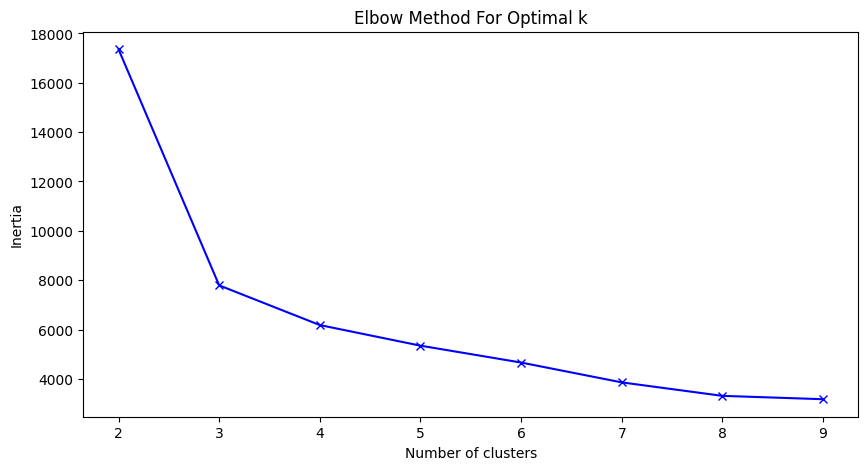

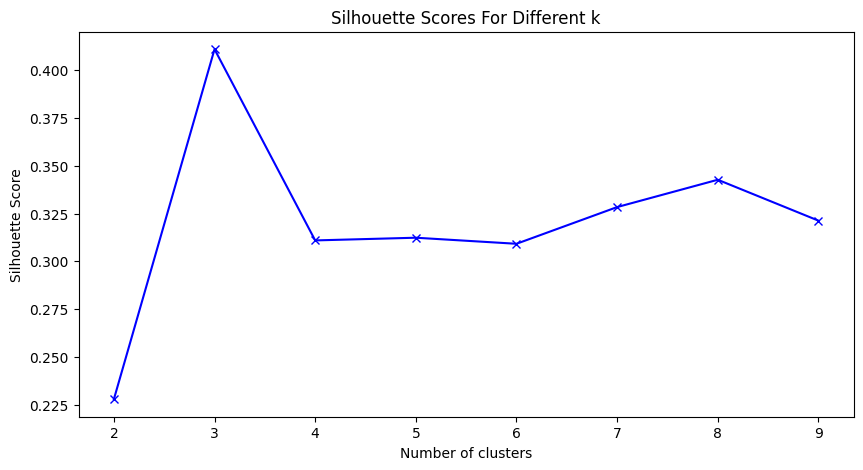

In [155]:
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

    # Calculate Silhouette Score
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.show()


In [156]:
derivatives = np.diff(inertia, 2)
elbow_point = np.argmax(derivatives) + 2
print(f"Suggested optimal clusters by derivative: {elbow_point}")

Suggested optimal clusters by derivative: 2


### Apply Clustering with the Optimal Number of Clusters

In [157]:
optimal_clusters = 3  # adding one to the elbow point

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

silhouette_vals = silhouette_samples(scaled_features, df['Cluster'])
df['Silhouette Value'] = silhouette_vals

# Silhouette plot for the chose number
plt.figure(figsize=(10, 8))
y_lower, y_upper = 0, 0
for i in range(optimal_clusters):
    cluster_silhouette_vals = silhouette_vals[df['Cluster'] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper

plt.xlabel('Silhouette coefficient')
plt.ylabel('Cluster')
plt.axvline(silhouette_vals.mean(), color="red", linestyle="--")
plt.show()


KeyError: 'Cluster'

### Analyze the Clusters

In [100]:
centroids = df.groupby('Cluster').mean().drop('store_id', axis=1)
centroids

AQUATIC_AND_REPTILE  GARDEN_SEED_L3  GARDENING_ACCESSORIES  \
Cluster                                                               
0                   0.812903       29.070968              29.625806   
1                      149.0          2206.0                    4.0   
2                   1.165153       18.815391                0.12019   

         POTTING_SOILS    DOTCOM  PATIO_AND_GARDEN_MISC_L3  
Cluster                                                     
0           112.834409       0.0                       0.0  
1                  7.0      91.0                     342.0  
2            48.961954  0.008214                  0.058366

In [122]:
centroids_normalized = (centroids - centroids.mean()) / centroids.std()
centroids_normalized

AQUATIC_AND_REPTILE  GARDEN_SEED_L3  GARDENING_ACCESSORIES  \
Cluster                                                               
0                   -0.57941       -0.573275               1.146217   
1                   1.154698        1.154691              -0.452113   
2                  -0.575288       -0.581416              -0.694104   

         POTTING_SOILS    DOTCOM  PATIO_AND_GARDEN_MISC_L3  
Cluster                                                     
0             1.061453 -0.577428                 -0.577498  
1            -0.924411  1.154701                  1.154701  
2            -0.137042 -0.577272                 -0.577202

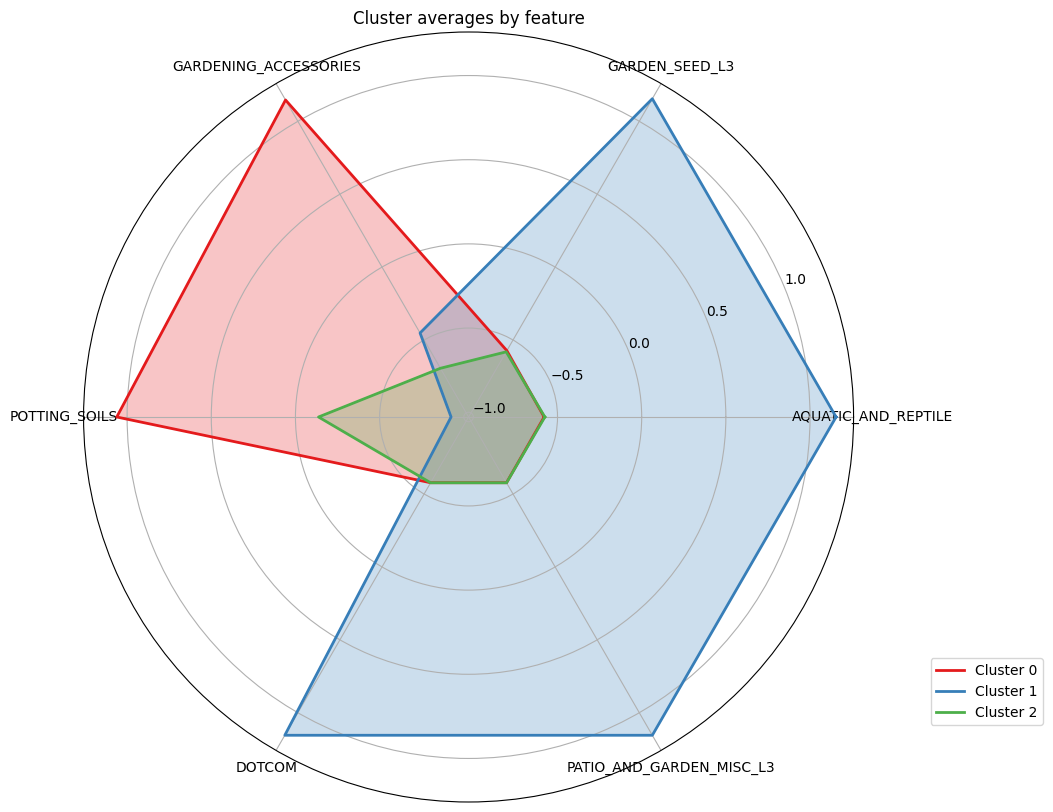

In [130]:
n_clusters = centroids_normalized.shape[0]
n_features = centroids_normalized.shape[1]
colors = sns.color_palette('Set1', n_clusters)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

labels = centroids_normalized.columns
angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
angles += angles[:1]

for i in range(n_clusters):
    values = centroids_normalized.loc[i].values.tolist()
    values += values[:1]
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.plot(angles, values, color=colors[i], linewidth=2, label=f'Cluster {i}')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Cluster averages by product category')
plt.legend(loc=(1.1, 0.1))

plt.show()

### Reduce the Dimensionality of the Data

First, we will use PCA to reduce the dimensionality of the data to two dimensions. Then, we will visualize the clusters using the reduced data.

In [97]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
df_with_pca = df.copy()
df_with_pca['PCA1'] = pca_features[:, 0]
df_with_pca['PCA2'] = pca_features[:, 1]

In [99]:
# Analyze the explained variance by each principal component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA1: {explained_variance[0]:.2f}")
print(f"Explained variance by PCA2: {explained_variance[1]:.2f}")


Explained variance by PCA1: 0.49
Explained variance by PCA2: 0.19


In [134]:
fig = px.scatter(df_with_pca, x='PCA1', y='PCA2', color='Cluster', hover_data=df.columns)
fig.show()

### Visualize Clusters Using t-SNE

t-SNE is a dimensionality reduction technique that is particularly well-suited for the visualization of high-dimensional datasets. It reduces the dimensionality of the data while preserving the relationships between the data points as much as possible.

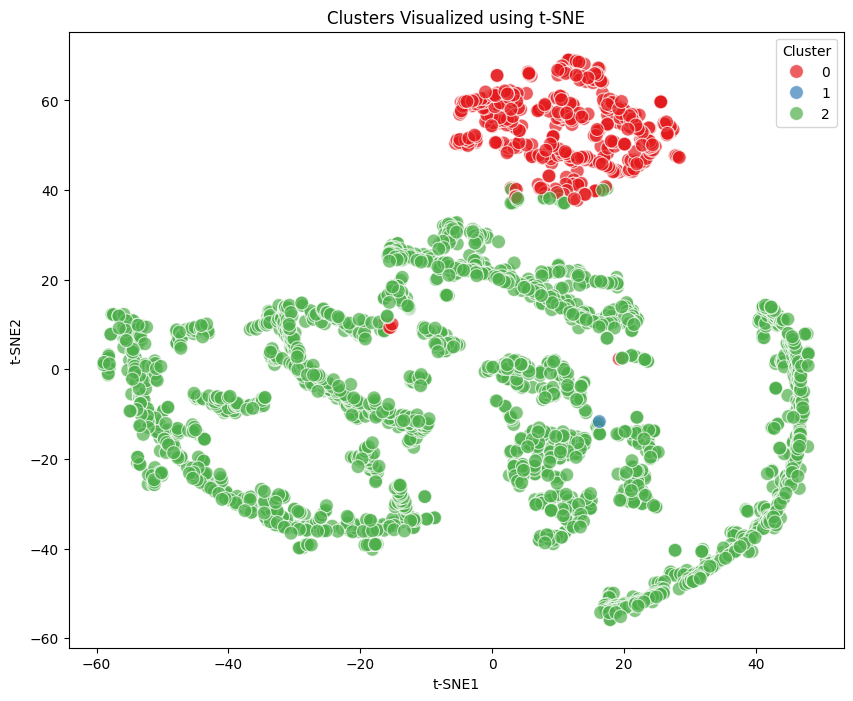

In [137]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)
df['t-SNE1'] = tsne_features[:, 0]
df['t-SNE2'] = tsne_features[:, 1]

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=df, palette='Set1', s=100, alpha=0.7)
plt.title('Clusters Visualized using t-SNE')
plt.show()

### Evaluate the Stability of the Clusters

To evaluate the stability of the clusters, we will resample the data multiple times and check how consistent the clusters are across the resampled datasets.
The stability of the clusters is calculated as the proportion of times a data point is assigned to the same cluster across the resampled datasets.
It can be interpreted as a measure of how robust the clustering is to variations in the data.

In [135]:
n_runs = 10
consistency = np.zeros((df.shape[0], n_runs))

for i in range(n_runs):
    df_resampled = resample(scaled_features, random_state=i)
    kmeans_resampled = KMeans(n_clusters=optimal_clusters, random_state=i)
    clusters_resampled = kmeans_resampled.fit_predict(df_resampled)
    consistency[:, i] = clusters_resampled

stability = np.mean(consistency == consistency[:, 0][:, None], axis=1)
df['Stability'] = stability
print(df[['Cluster', 'Stability']].head())


   Cluster  Stability
0        2        0.5
1        0        0.3
2        2        0.2
3        2        0.5
4        2        0.6
